##Educação em geofísica
Material didático - algoritmos para aulas de geofísica
#Magnetometria - Redução ao Polo

Citação deste material: Szameitat, L.S.A., Bongiolo, A.B.S. (in prep.). Educação em geofísica: recursos computacionais para tratamento de dados magnetométricos e gravimétricos em sala de aula. Boletim Paranaense de Geociências.

####Agradecimentos
As autoras agradecem ao Geól. Julio Lyrio (Petrobras) pela colaboração na adaptação para baixas latitudes.

####Outras Referencias
#####• Blakely, R. (1996). Potential Theory in Gravity and Magnetic Applications.Cambridge University, 464p.
#####• Bongiolo, A. B. S., Szameitat, L. S. A., Stevanato, R., Canata, R. E., Pereira, H. G., & Antonelli, F. (2022). Geophysical surveying for the detection of ferrous-based objects: possibilities for depth estimative combining analytic signal and vertical integral of the anomalous magnetic field. Brazilian Journal of Geophysics, 40(1), 43-52.

Importar bibliotecas

In [1]:
import numpy as np
import scipy.fftpack
from math import radians, sin, cos, sqrt
import matplotlib.pyplot as plt
#import seaborn as sb
import pandas as pd

##Funções
Funções para trabalhar com os dados do campo magnético anômalo, adaptadas de Blakely (1996).

In [11]:
def DirCos(i, d, az):
    '''
    Parametros
    ----------
    i - inclinacao
    d - declinacao
    az - azimute
    '''
    a = cos(radians(i))*cos(radians(d)-radians(az))
    b = cos(radians(i))*sin(radians(d)-radians(az))
    c = sin(radians(i))
    return a, b, c

def Kvalue(i, j, nx, ny, dkx, dky):
    '''
    Parametros
    ----------
    i, j - indices
    nx, ny -  numero de amostras em x e y
    dkx, dky -
    '''
    nyqx = nx / 2 + 1
    nyqy = ny / 2 + 1
    kx = float()
    ky = float()
    if j <= nyqx:
        kx = (j-1) * dkx
    else:
        kx = (j-nx-1) * dkx
    if i <= nyqy:
        ky = (i-1) * dky
    else:
        ky = (i-ny-1) * dky
    return kx, ky

def NewVecLL(grid, nx, ny, dx, dy, fi1, fd1, mi1, md1, fi2, fd2, mi2, md2):
    '''
    NewVecLL(grid, nx, ny, dx, dy, fi1, fd1, mi1, md1, fi2, fd2, mi2, md2)
    NewVec() original com adaptação para baixas latitudes.
    Objetivo: simular mudanças na direção de magnetização
    Para redução ao polo, deve-se usar mi2 = fi2 = 90
    Parameters
    ----------
        grid - array de duas dimensões contendo o campo total
        nx, ny (int):
            numero de amostras em x e y
        dx, dy (int):
            distancia entre amostras em x e y
        mi1, md1 - (graus):
            inclinacao e declinacao da magnetizacao
        fi1, fd1 - (graus):
            Magnetizacao do campo geomagnetico atual (inclinacao, declinacao)
        mi2, md2 - (graus):
            Nova direção de magnetizacao (inclinacao, declinacao)
        fi2, fd2 - (graus):
            Nova magnetizacao do campo geomagnetico (inclinacao, declinacao)
    '''

    dkx = 2. * np.pi / (nx * dx)
    dky = 2. * np.pi / (ny * dy)

    #Cossenos direcionais
    mx1, my1, mz1 = DirCos(mi1, md1, 0.)
    fx1, fy1, fz1 = DirCos(fi1, fd1, 0.)
    mx2, my2, mz2 = DirCos(mi2, md2, 0.)
    fx2, fy2, fz2 = DirCos(fi2, fd2, 0.)

    #Transformada de Fourier usando scipy
    gridfft = scipy.fftpack.fft2(grid)
    gridfft = np.reshape(gridfft, nx*ny) # muda para forma 1D

    #Filtro de fase (lat menor que -20 e maior que 20)
    if mi1 < -20 or mi1 > 20:
        for j in range (1, nx+1):
            for i in range (1, ny+1):
                ij = (j-1) * ny + i
                if ij == 1:
                    cphase = 0.0
                else:
                    kx, ky = Kvalue(i, j, nx, ny, dkx, dky) # ** funcao Kvalue
                    k = sqrt(kx**2 + ky**2)
                    thetam1 = complex(mz1, (kx*mx1 + ky*my1) / k)
                    thetaf1 = complex(fz1, (kx*fx1 + ky*fy1) / k)
                    thetam2 = complex(mz2, (kx*mx2 + ky*my2) / k)
                    thetaf2 = complex(fz2, (kx*fx2 + ky*fy2) / k)
                    cphase = thetam2 * thetaf2 / (thetam1 * thetaf1)

                # Filtra cada item do grid
                gridfft[ij-1] = gridfft[ij-1]*cphase

    #Filtro de fase (baixas latitudes)
    elif mi1 > -21 and mi1 < 21:
        if mi1 < 0:
            c = -90-mi1
        else:
            c = 90-mi1
        for j in range (1, nx+1):
            for i in range (1, ny+1):
                ij = (j-1) * ny + i
                if ij == 1:
                    cphase = 0.0
                    cphase2 = 0.0
                else:
                    kx, ky = Kvalue(i, j, nx, ny, dkx, dky)

                    k = sqrt(kx**2 + ky**2)
                    thetam1 = complex(mz1, (kx*mx1 + ky*my1) / k)
                    thetaf1 = complex(fz1, (kx*fx1 + ky*fy1) / k)
                    thetam2 = complex(mz2, (kx*mx2 + ky*my2) / k)
                    thetaf2 = complex(fz2, (kx*fx2 + ky*fy2) / k)
                    cphase = thetam2 * thetaf2 / (thetam1 * thetaf1)
                    #--- Baixas latitudes ---
                    cx, cy, cz = DirCos(c, md1, 0.)
                    thetam3 = complex(mz1, (-kx*mx1 - ky*my1) / k)
                    thetac1 = complex(cz, (kx*cx + ky*cy) / k)
                    thetac2 = complex(cz, (-kx*cx - ky*cy) / k)
                    cphase2 = cphase * (thetam1 * thetam3 / (thetac1 * thetac2))
                    #------------------------
                # Filtra cada item do grid
                gridfft[ij-1] = gridfft[ij-1] * cphase2

    #Fourier
    gridfft = np.reshape(gridfft, (ny, nx)) # retorna para formato 2D
    gridifft = scipy.fftpack.ifft2(gridfft)
    grid = gridifft.real #usamos apenas a parte real

    return grid

##Arquivo de entrada
Carregar arquivo de dados no ambiente. O arquivo deve conter colunas de coordenadas (x,y) e campo anômalo. O arquivo de exemplo contém uma anomalia dipolar referente ao levantamento magnetométrico realizado no sítio controlado do LPGA-UFPR (Bongiolo et al., 2022)

In [3]:
#Opção 1 - Arquivo para exercício

#Anomalia do campo magnético adquirida no Sítio Controlado LPGA-UFPR (Bongiolo et al., 2022)
arquivo = 'https://raw.githubusercontent.com/lszam/ensino/main/geof_mag/magsitio_anomalia.TXT'

#Opção 2 - Arquivo próprio
#from google.colab import files
#import io
#uploaded=files.upload()
#arquivo = 'magsitio_anomalia.TXT'#inserir o nome do arquivo nesta variável

Abrir e visualizar o arquivo de entrada:

In [4]:
dados = pd.read_csv(arquivo, header = 0, delimiter = ";")
dados

,LESTE,NORTE,CMA
0,677773.00,7184160.5,3.530748
1,677773.25,7184160.5,5.342271
2,677773.50,7184160.5,7.169139
3,677773.75,7184160.5,8.319186
4,677774.00,7184160.5,8.568579
...,...,...,...
470,677776.50,7184166.5,94.305969
471,677776.75,7184166.5,91.583809
472,677777.00,7184166.5,89.756935
473,677777.25,7184166.5,89.502563


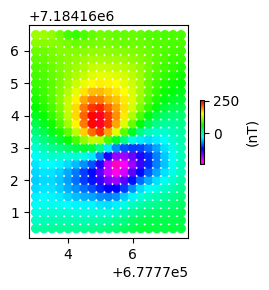

In [5]:
#Plotar
plt.figure(figsize=(3, 3))  #tamanho da figura
entrada_mag = plt.scatter(dados.LESTE, dados.NORTE, c=dados.CMA, cmap='gist_rainbow_r')
plt.colorbar(entrada_mag, label="(nT)", shrink=0.3) #barra de cores
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

### Organizando os grids de entrada (leste, norte, campo mag)

In [6]:
# .to_numpy() converte os valores de dentro da série tipo Pandas em um array NumPy
vetor_LESTE = dados.LESTE.to_numpy()
vetor_NORTE = dados.NORTE.to_numpy()
vetor_CMA = dados.CMA.to_numpy()

#Elementos a leste e a norte
pontos_LESTE=[]
pontos_NORTE=[]

#Adicionar valores não repetidos
[pontos_LESTE.append(item) for item in vetor_LESTE if not pontos_LESTE.count(item)]
[pontos_NORTE.append(item) for item in vetor_NORTE if not pontos_NORTE.count(item)]

#Salvar número de itens a leste e a norte
n_l = np.size(pontos_LESTE)
n_n = np.size(pontos_NORTE)

#Obter a distancia em x e y
dX, dY = np.abs(pontos_LESTE[0]-pontos_LESTE[1]), np.abs(pontos_NORTE[0]-pontos_NORTE[1])

#Grid
grid_LESTE, grid_NORTE = np.meshgrid(pontos_LESTE, pontos_NORTE) #mesh
grid_CMA = np.reshape(vetor_CMA, (n_n, n_l)) #de 1D para 2D

#Salva as posições dos prismas como array
pontos_LESTE = np.array(pontos_LESTE)
pontos_NORTE = np.array(pontos_NORTE)


# Redução ao polo

Definir parâmetros e aplicar a transformação no dado

In [7]:
fi1 = int(-30)
fd1 = int(-20)
mi1 = int(-30)
md1 = int(-20)
fi2 = 90 #rtp
mi2 = 90 #rtp
fd2 = 0 #rtp
md2 = 0 #rtp

#Transformação
grid_RTP = NewVecLL(grid_CMA, n_l, n_n, dX, dY, fi1, fd1, mi1, md1, fi2, fd2, mi2, md2)

dados = dados.assign(RTP = np.reshape(grid_RTP, (n_l*n_n)))
dados

,LESTE,NORTE,CMA,RTP
0,677773.00,7184160.5,3.530748,-383.222792
1,677773.25,7184160.5,5.342271,-397.929228
2,677773.50,7184160.5,7.169139,-389.263660
3,677773.75,7184160.5,8.319186,-349.720060
4,677774.00,7184160.5,8.568579,-327.140321
...,...,...,...,...
470,677776.50,7184166.5,94.305969,-266.585880
471,677776.75,7184166.5,91.583809,-267.954652
472,677777.00,7184166.5,89.756935,-272.417605
473,677777.25,7184166.5,89.502563,-244.069051


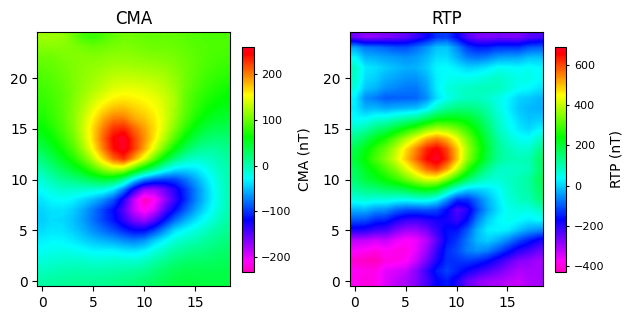

In [8]:
#Exibir mapas do dado de entrada e de saída
plt.subplot(1, 2, 1)
plt.title("CMA")
mapa_cma = plt.imshow(grid_CMA, cmap='gist_rainbow_r', interpolation='bilinear')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis() #eixo com zero na base
colorbar_cma = plt.colorbar(mapa_cma, label="CMA (nT)", shrink=0.5)
colorbar_cma.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_cma.ax.tick_params(labelsize=8)  # Define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.title("RTP")
mapa_rtp = plt.imshow(grid_RTP, cmap='gist_rainbow_r', interpolation='bilinear')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis() #eixo com zero na base
colorbar_rtp = plt.colorbar(mapa_rtp, label="RTP (nT)", shrink=0.5)
colorbar_rtp.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_rtp.ax.tick_params(labelsize=8)  # Define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"
plt.tight_layout()

#Salvar figura
plt.savefig('mag_rtp_py.png', dpi=300, bbox_inches='tight')

plt.show()

Salvar a saída como arquivo csv

In [9]:
dados.to_csv("mag_rtp_py.csv")

Extra - Funções adicionais